# Use-case-III: Adversarial Image Detection

Feature attribution for an adversarial sample differs from its benign counterpart because the adversarial perturbation \textit{flips} the model prediction, causing the explanation method to attribute importance to different features. The feature attribution for benign and adversarial images differs. Interestingly, this difference in feature attribution can be measured using simple statistics of dispersion.

In this notebook, we demonstrate the application of explanation methods in detecting adversarial samples for MNIST dataset. 

We use [quantus](https://quantus.readthedocs.io/en/latest/) for computing feature attribution.

You can download the trained models from [this](https://drive.google.com/drive/folders/1_Az6w5NMkWGyiXpmf0PNJqJdohXMbaiA?usp=sharing) google drive folder. 

In [107]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST as MNISTDataset
import matplotlib
import matplotlib.pyplot as plt
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)
import gc
from captum.attr import *
import quantus

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
test_set = torchvision.datasets.MNIST(root='./sample_data', train=False, transform=transformer, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=50, pin_memory=True)

# Load model

In [4]:
#for natural and adversarial LeNet Model 
class LeNet_normal(torch.nn.Module):
    """Network architecture from: https://github.com/ChawDoe/LeNet5-MNIST-PyTorch."""
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(1, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.relu_1 = torch.nn.ReLU()
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.relu_2 = torch.nn.ReLU()
        self.fc_1 = torch.nn.Linear(256, 120)
        self.relu_3 = torch.nn.ReLU()
        self.fc_2 = torch.nn.Linear(120, 84)
        self.relu_4 = torch.nn.ReLU()
        self.fc_3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(x.shape[0], -1)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
normal_model = LeNet_normal()
normal_model.to(device)
normal_model.load_state_dict(torch.load('mnist models/state_dict.pth'))
normal_model.eval()

LeNet_normal(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_2): ReLU()
  (fc_1): Linear(in_features=256, out_features=120, bias=True)
  (relu_3): ReLU()
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (relu_4): ReLU()
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)

# Generate adversarial samples using PGD attack

In [62]:
def make_attack(x_batch, y_batch, eps=0.3): 
    images_pgd = projected_gradient_descent(normal_model, x_batch, eps, 0.01, 40, np.inf)
    _, y_pred_pgd = normal_model(images_pgd).max(1)
    index = (y_pred_pgd != y_batch)
    pgd_images = images_pgd[index]
    y_pred_pgd = y_pred_pgd[index]
    return pgd_images, y_pred_pgd

# See distribution for a test batch

In [10]:
eps = 0.3
# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = next(iter(test_loader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

images, labels = x_batch.to(device), y_batch.to(device)
images_pgd = projected_gradient_descent(normal_model, images, eps, 0.01, 40, np.inf)
_, y_pred_pgd = normal_model(images_pgd).max(1)

# Generate explanations for normal and adv images using gradient and integrated gradient

In [11]:
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

a_batch_intgrad = quantus.normalise_func.normalise_by_negative(IntegratedGradients(normal_model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_benign = quantus.normalise_func.normalise_by_negative(Saliency(normal_model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())

In [12]:
images_pgd, y_pred_pgd = images_pgd.to(device), y_pred_pgd.to(device)

In [13]:
a_batch_adv_samples = quantus.normalise_func.normalise_by_negative(Saliency(normal_model).attribute(inputs=images_pgd, target=y_pred_pgd).sum(axis=1).cpu().numpy())
adv_intgrad = quantus.normalise_func.normalise_by_negative(IntegratedGradients(normal_model).attribute(inputs=images_pgd, target=y_pred_pgd, baselines=torch.zeros_like(images_pgd)).sum(axis=1).detach().cpu().numpy())

In [14]:
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

In [215]:
#images_pgd, y_pred_pgd = images_pgd.detach().cpu().numpy(), y_pred_pgd.detach().cpu().numpy()

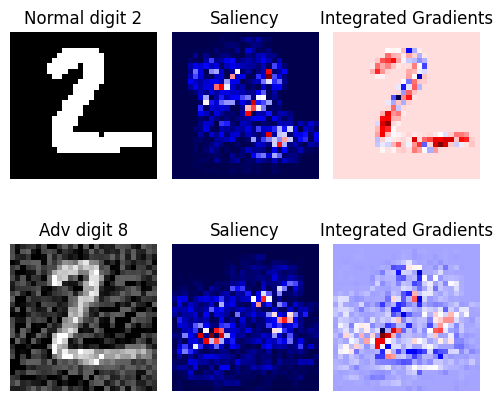

In [16]:
# Plot explanations of normal images!
nr_images = 2
fig, axes = plt.subplots(nrows=nr_images, ncols=3, figsize=(nr_images*2.5, int(nr_images*3)))
images_pgd = images_pgd.cpu()
y_pred_pgd = y_pred_pgd.cpu()
#plot normal
axes[0, 0].imshow((np.reshape(x_batch[1], (28, 28)) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
axes[0, 0].title.set_text(f"Normal digit {y_batch[1].item()}")
axes[0, 0].axis("off")
axes[0, 1].imshow(a_batch_benign[1], cmap="seismic")
axes[0, 1].title.set_text(f"Saliency")
axes[0, 1].axis("off")  
axes[0, 2].imshow(a_batch_intgrad[1], cmap="seismic")
axes[0, 2].title.set_text(f"Integrated Gradients")
axes[0, 2].axis("off")
plt.tight_layout()

#plot adv
axes[1, 0].imshow(np.transpose((images_pgd[1].detach().numpy()),(1,2,0)), cmap="gray")
axes[1, 0].title.set_text(f"Adv digit {y_pred_pgd[1].item()}")
axes[1, 0].axis("off")
axes[1, 1].imshow(a_batch_adv_samples[1], cmap="seismic")
axes[1, 1].title.set_text(f"Saliency")
axes[1, 1].axis("off")  
axes[1, 2].imshow(adv_intgrad [1], cmap="seismic")
axes[1, 2].title.set_text(f"Integrated Gradients")
axes[1, 2].axis("off")
plt.tight_layout()

plt.savefig("MNISTAdversarialBenignImageExplanation.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Use standard statistical measures for adversarial sample detection

- Mean absolute deviation: It is average deviation from mean.
- Median Absolute Deviation: It is median deviation from median.
- Interquartile range: Interquartile range is defined as the difference between the 25th and 75th percentile.  Hence the interquartile range describes the middle 50% of observations. It is not affected by extreme values.


In [63]:
def mean_abs_dev(attr): 
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        avg = np.mean(a)
        deviation = a - avg 
        absolute_deviation = np.abs(deviation)
        result = np.mean(absolute_deviation)
        scores.append(result)
    return scores    

In [64]:
def median_abs_dev(attr): 
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        med = np.median(a)
        deviation = a - med 
        abs_deviation = np.abs(deviation)
        result = np.median(abs_deviation)
        scores.append(result)
    return scores 

In [65]:
def iqr(attr):
    #inter-quartile range
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        score_75 = np.percentile(a, 75)
        score_25 = np.percentile(a, 25)
        score_qt = score_75 - score_25
        scores.append(score_qt)
    return scores
    

# Relative measure of dispersion 

-  A relative measure of dispersion is used to compare the distribution of two or more datasets. A given series of data is accurately exhibited by the absolute measures of dispersion. But one of the major demerits of this is that if there is a need to compare dispersion for a series of different units then it cannot be used. The above-mentioned comparison can be done with relative dispersion.  Another name of relative measures of dispersion is coefficients of dispersion.

In [66]:
#relative measure of dispersion
def coef_var(attr):
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        m = np.mean(a)
        st = np.std(attr[i])
        sc = m/st
        scores.append(sc)
    return scores

In [67]:
#relative measure of dispersion

## Coefficient of quartile dev

def coef_iqr(attr):
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        score_75 = np.percentile(a, 75)
        score_25 = np.percentile(a, 25)
        score_qt = (score_75 - score_25)/(score_75 + score_25+0.000001)
        scores.append(score_qt)
    return scores
    

In [80]:

#store statistical measures for mnist samples

meanAbs_adv =[]
meanAbs_ben = []

medianAbs_adv = []
medianAbs_ben = []

iqr_adv = []
iqr_ben = []

coef_var_adv =[]
coef_var_ben=[]

coef_iqr_adv = []
coef_iqr_ben = []

for step, (x_batch, y_batch) in enumerate(test_loader):
    if step % 20 ==0:
        print('Step ', step)
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
    images_pgd, y_pred_pgd=make_attack(x_batch, y_batch, eps=0.3)
    
   # images_pgd = projected_gradient_descent(normal_model, x_batch, eps, 0.01, 40, np.inf)
    #_, y_pred_pgd = normal_model(images_pgd).max(1)
    
    a_batch_benign = quantus.normalise_func.normalise_by_negative(Saliency(normal_model).attribute(inputs=x_batch, target=y_batch).sum(axis=1).cpu().numpy())
    #a_batch_benign = quantus.normalise_func.normalise_by_negative(IntegratedGradients(normal_model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())

    images_pgd, y_pred_pgd = images_pgd.to(device), y_pred_pgd.to(device)
    a_batch_adv_samples = quantus.normalise_func.normalise_by_negative(Saliency(normal_model).attribute(inputs=images_pgd, target=y_pred_pgd).sum(axis=1).cpu().numpy())
    #a_batch_adv_samples = quantus.normalise_func.normalise_by_negative(IntegratedGradients(normal_model).attribute(inputs=images_pgd, target=y_pred_pgd, baselines=torch.zeros_like(images_pgd)).sum(axis=1).detach().cpu().numpy())
    
   
    meanAbs_adv += mean_abs_dev(a_batch_adv_samples)
    meanAbs_ben += mean_abs_dev(a_batch_benign)
    
    medianAbs_adv += median_abs_dev(a_batch_adv_samples)
    medianAbs_ben += median_abs_dev(a_batch_benign)
    
    
    iqr_adv += iqr(a_batch_adv_samples)
    iqr_ben += iqr(a_batch_benign)
    
    coef_var_adv += coef_var(a_batch_adv_samples)
    coef_var_ben += coef_var(a_batch_benign)
    
    coef_iqr_adv += coef_iqr(a_batch_adv_samples)
    coef_iqr_ben += coef_iqr(a_batch_benign)
    
    #if step == 100:
     #   break 
    
    
    

Step  0
Step  20
Step  40
Step  60
Step  80
Step  100
Step  120
Step  140
Step  160
Step  180


# Plots

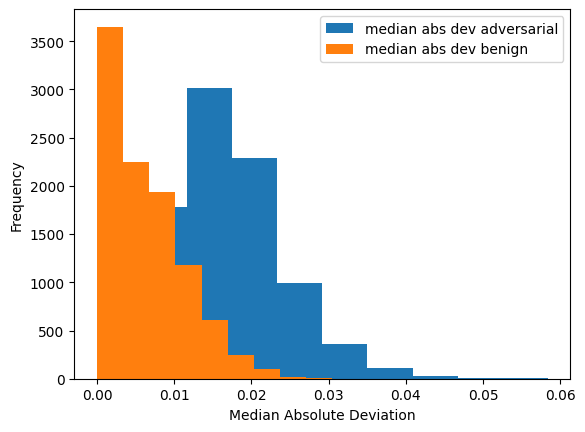

In [82]:
import matplotlib.pyplot as plt 
plt.hist(medianAbs_adv, label="median abs dev adversarial") 
plt.hist(medianAbs_ben, label="median abs dev benign")
plt.xlabel("Median Absolute Deviation")
plt.ylabel("Frequency")
plt.legend()
#plt.savefig("statPlots/MNISTMedianAbsDev.pdf", format="pdf", bbox_inches="tight")
plt.show()

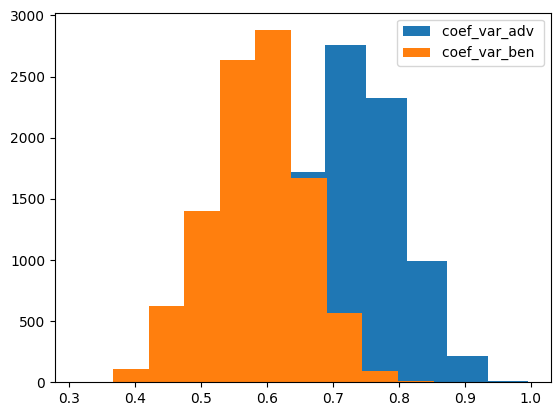

In [83]:
import matplotlib.pyplot as plt 
plt.hist(coef_var_adv, label="coef_var_adv ") 
plt.hist(coef_var_ben, label="coef_var_ben ")
plt.legend()
plt.show()

In [84]:
coef_iqr_ben_ = [x for x in coef_iqr_ben if str(x) != 'nan']
coef_iqr_adv_ =  [x for x in coef_iqr_adv if str(x) != 'nan']

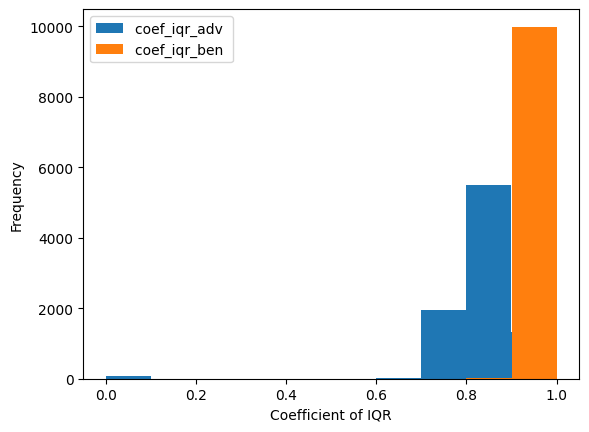

In [87]:
import matplotlib.pyplot as plt 
plt.hist(coef_iqr_adv_, label="coef_iqr_adv ") 
plt.hist(coef_iqr_ben_, label="coef_iqr_ben ")
plt.xlabel("Coefficient of IQR")
plt.ylabel("Frequency")
plt.legend()
#plt.savefig("statPlots/MNISTCoefIQRPlot.pdf", format="pdf", bbox_inches="tight")
plt.show()

# define a thresholding method to detect adversarial sample

In [99]:
def compute_precision(TP, FP): 
    return TP/(TP+FP)

def compute_recall(TP, FN):
    return TP/(TP+FN)

In [100]:
# use Coefficent of IQR to detect adversarial sample 

detect = 0
for value in coef_iqr_adv_:
    if value <=0.925:
        detect=detect+1
print(len(coef_iqr_adv_), detect, detect/len(coef_iqr_adv_))


8851 8176 0.9237374307987798


In [101]:
#benign sample

i = 0
for value in coef_iqr_ben_:
    if value >=0.925:
        i=i+1
print(len(coef_iqr_ben_), i, i/len(coef_iqr_ben_))


10000 9949 0.9949


In [102]:
print("precision is:", compute_precision(8176, 10000-9949))
print("recall is:", compute_recall(9949, 8851-8176))

precision is: 0.9938008994773307
recall is: 0.9364646084337349


In [105]:
#use median absolute deviation 
detect = 0
for value in medianAbs_adv:
    if value >=0.011:
        detect=detect+1
print(len(medianAbs_adv), detect, detect/len(medianAbs_adv))


#for benign
i = 0
for value in medianAbs_ben:
    if value <= 0.011:
        i=i+1
print(len(medianAbs_ben), i, i/len(medianAbs_ben))

8851 7100 0.8021692464128347
10000 8174 0.8174


In [106]:
print("precision is:", compute_precision(8851, 10000-8174))
print("recall is:", compute_recall(8174, 8851-7100))

precision is: 0.8289781773906528
recall is: 0.8235768261964735
